In [1]:
import os

import numpy
import tensorflow as tf
import json
import pandas

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

from tools_keras import *

In [2]:
numpy.random.seed(42)

In [3]:
chips = numpy.load('../../chips_gb/multilabel_chip_8.npy')

In [4]:
chips.shape

(135264, 8, 8, 3)

In [5]:
sorter = numpy.random.choice(numpy.arange(0, len(chips)), len(chips))

In [6]:
chips = chips[sorter]

In [7]:
target = pandas.read_parquet("../../chips_gb/chip_proportions_8.pq").drop(columns="geometry").iloc[sorter]

In [8]:
target = target.drop(columns=["9_3", "9_6", "9_7", "9_8"])

In [9]:
group_mapping = [
    ['9_0', '9_1', '9_2', '9_4', '9_5'],
    ['2_0'], 
    ['2_1'], 
    ['2_2'],
    ['1_0'], 
    ['3_0'], 
    ['5_0'], 
    ['6_0'], 
    ['8_0'],
    ['0_0'],
    ['4_0'],
    ['7_0']
]

group_naming = [
    "Urbanity", 
    "Dense residential neighbourhoods",
    "Connected residential neighbourhoods",
    "Dense urban neighbourhoods",
    "Accessible suburbia",
    "Open sprawl",
    "Warehouse_Park land",
    "Gridded residential quarters",
    "Disconnected suburbia",
    "Countryside agriculture", 
    "Wild countryside", 
    "Urban buffer"
]

cd2nm = {}
for codes, name in zip(group_mapping, group_naming):
    for code in codes:
        cd2nm[f'{code}'] = name.lower().replace(" ", "_").replace("/", "_")
cd2nm = pandas.Series(cd2nm)
    
target = target.rename(columns=cd2nm).groupby(level=0, axis=1).sum()

In [10]:
mask = target.sum(axis=1) > 0.5
target_no_water = target[mask]
chips = chips[mask]

In [11]:
batch_size = 32
split1 = int(chips.shape[0] * 0.7)
split2 = int(chips.shape[0] * 0.85)


train_dataset = tf.data.Dataset.from_tensor_slices((chips[:split1], target_no_water.values[:split1]))
test_dataset = tf.data.Dataset.from_tensor_slices((chips[split1:split2], target_no_water.values[split1:split2]))
secret_dataset = tf.data.Dataset.from_tensor_slices((chips[split2:], target_no_water.values[split2:]))

train_dataset = train_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(batch_size=batch_size)
secret_dataset = secret_dataset.batch(batch_size=batch_size)

2022-05-08 09:10:56.649477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6395 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:21:00.0, compute capability: 7.5


In [12]:
preprocessing_and_augmentation = keras.Sequential(
    [
        layers.Resizing(224, 224, crop_to_aspect_ratio=True),
    ]
)

In [20]:
base_model = keras.applications.EfficientNetB4(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False, # Do not include the ImageNet classifier at the top.
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(8, 8, 3))
x = preprocessing_and_augmentation(inputs)
x = preprocess_input(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(12, activation="sigmoid")(x)

model = keras.Model(inputs, predictions)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8, 8, 3)]         0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               229504    
                                                                 
 dense_3 (Dense)             (None, 12)                1548      
                                                           

In [21]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mean_squared_error", "accuracy"],
)

In [22]:
weights = target.sum().max() / target.sum()

In [23]:
class_weights = {k:w for k, w in enumerate(weights.values)}

In [24]:
specs = {
    "folder": "../../ai/gb_8_multiclass/"

}

model_folder = specs['folder'] + "model"
log_folder = specs['folder'] + "logs"
pred_folder = specs['folder'] + "pred"
json_folder = specs['folder'] + "json"

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, min_delta=0.02, verbose=True),
    ModelCheckpoint(
        filepath=f"{model_folder}/{model.name}_best",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
    ),
    TensorBoard(log_dir=os.path.join(log_folder, model.name), histogram_freq=1)
]

In [25]:
t0 = time.time()

epochs = 200
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, class_weight=class_weights, callbacks=callbacks,)

t1 = time.time()
specs["runtime"] = t1 - t0

Epoch 1/200


2022-05-08 09:12:36.348172: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


2474/2474 [==============================] - ETA: 0s - loss: 0.1047 - mean_squared_error: 0.0640 - accuracy: 0.2705

2022-05-08 09:18:03.871983: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../ai/gb_8_multiclass/model/model_1_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2474/2474 [==============================] - 371s 147ms/step - loss: 0.1047 - mean_squared_error: 0.0640 - accuracy: 0.2705 - val_loss: 0.0622 - val_mean_squared_error: 0.0622 - val_accuracy: 0.2992
Epoch 2/200
2474/2474 [==============================] - ETA: 0s - loss: 0.1015 - mean_squared_error: 0.0620 - accuracy: 0.2985INFO:tensorflow:Assets written to: ../../ai/gb_8_multiclass/model/model_1_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2474/2474 [==============================] - 363s 147ms/step - loss: 0.1015 - mean_squared_error: 0.0620 - accuracy: 0.2985 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - val_accuracy: 0.3045
Epoch 3/200
2474/2474 [==============================] - 314s 127ms/step - loss: 0.1006 - mean_squared_error: 0.0615 - accuracy: 0.3072 - val_loss: 0.0620 - val_mean_squared_error: 0.0620 - val_accuracy: 0.3022
Epoch 4/200
2474/2474 [==============================] - ETA: 0s - loss: 0.1000 - mean_squared_error: 0.0611 - accuracy: 0.3141INFO:tensorflow:Assets written to: ../../ai/gb_8_multiclass/model/model_1_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2474/2474 [==============================] - 365s 147ms/step - loss: 0.1000 - mean_squared_error: 0.0611 - accuracy: 0.3141 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - val_accuracy: 0.3049
Epoch 5/200
2474/2474 [==============================] - 314s 127ms/step - loss: 0.0995 - mean_squared_error: 0.0608 - accuracy: 0.3171 - val_loss: 0.0621 - val_mean_squared_error: 0.0621 - val_accuracy: 0.3022
Epoch 6/200
2474/2474 [==============================] - ETA: 0s - loss: 0.0991 - mean_squared_error: 0.0606 - accuracy: 0.3221INFO:tensorflow:Assets written to: ../../ai/gb_8_multiclass/model/model_1_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2474/2474 [==============================] - 365s 147ms/step - loss: 0.0991 - mean_squared_error: 0.0606 - accuracy: 0.3221 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - val_accuracy: 0.3054
Epoch 00006: early stopping


In [26]:
model.save(f"{model_folder}/{model.name}", save_format="tf")

INFO:tensorflow:Assets written to: ../../ai/gb_8_multiclass/model/model_1/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [27]:
nn = "efficinetnet"
bridge = "pooling"
toplayer = "softmax"
n_class = 12

meta = {
    # Metadata about run
    "meta_n_class": n_class,
    "meta_class_map": group_mapping,
    "meta_class_names": group_naming,
    "meta_chip_size": 8,
    # Model
    "model_name": model.name,
    "model_bridge": bridge,
    "model_toplayer": toplayer,
}
meta["meta_runtime"] = specs["runtime"]

subsets = {
    "train": train_dataset,
    "val": test_dataset,
    "secret": secret_dataset,
}
labels = {
    "train": numpy.argmax(target_no_water.values[:split1], axis=1),
    "val": numpy.argmax(target_no_water.values[split1:split2], axis=1),
    "secret": numpy.argmax(target_no_water.values[split2:], axis=1),
}
# Performance
for subset in subsets:
    print(f"assessing performance of {subset} dataset")
    dataset = subsets[subset]
    y_pred_probs = model.predict(dataset)

    os.makedirs(pred_folder, exist_ok=True)
    np.save(os.path.join(pred_folder, model.name + f"_{subset}.npy"), y_pred_probs)
    print(f"prediction of {subset} saved")
    
    y_pred = np.argmax(y_pred_probs, axis=1)
    y = labels[subset]
    top_prob, wc_accuracy, wc_top_prob = within_class_metrics(
        y, y_pred, y_pred_probs
    )
    # Accuracy
    meta[f"perf_model_accuracy_{subset}"] = accuracy(y, y_pred)
    # Prob for top class
    meta[f"perf_avg_prob_top_{subset}"] = top_prob
    # Within-class accuracy
    meta[f"perf_within_class_accuracy_{subset}"] = wc_accuracy
    # Within-class avg. prob for top class
    meta[f"perf_within_class_avg_prob_top_{subset}"] = wc_top_prob
    # Full confusion matrix
    meta[f"perf_confusion_{subset}"] = confusion_matrix(y, y_pred, int(n_class))
    print(
        f"perf_model_accuracy for {subset}: {meta[f'perf_model_accuracy_{subset}']}"
    )

os.makedirs(json_folder, exist_ok=True)
with open(
    os.path.join(json_folder, model.name + ".json"), "w", encoding="utf-8"
) as f:
    f.write(json.dumps(meta, indent=4, cls=NumpyEncoder).replace("NaN", "null"))

assessing performance of train dataset
prediction of train saved
perf_model_accuracy for train: 0.31584665179252625
assessing performance of val dataset
prediction of val saved
perf_model_accuracy for val: 0.3054114580154419
assessing performance of secret dataset
prediction of secret saved
perf_model_accuracy for secret: 0.3014029562473297


See the probability distributions for secret

<AxesSubplot:ylabel='Frequency'>

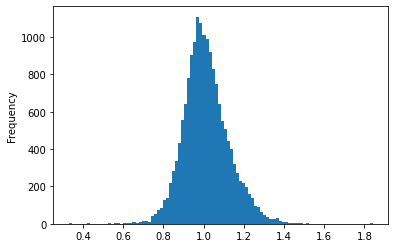

In [28]:
pandas.Series(y_pred_probs.sum(axis=1)).plot.hist(bins=100)

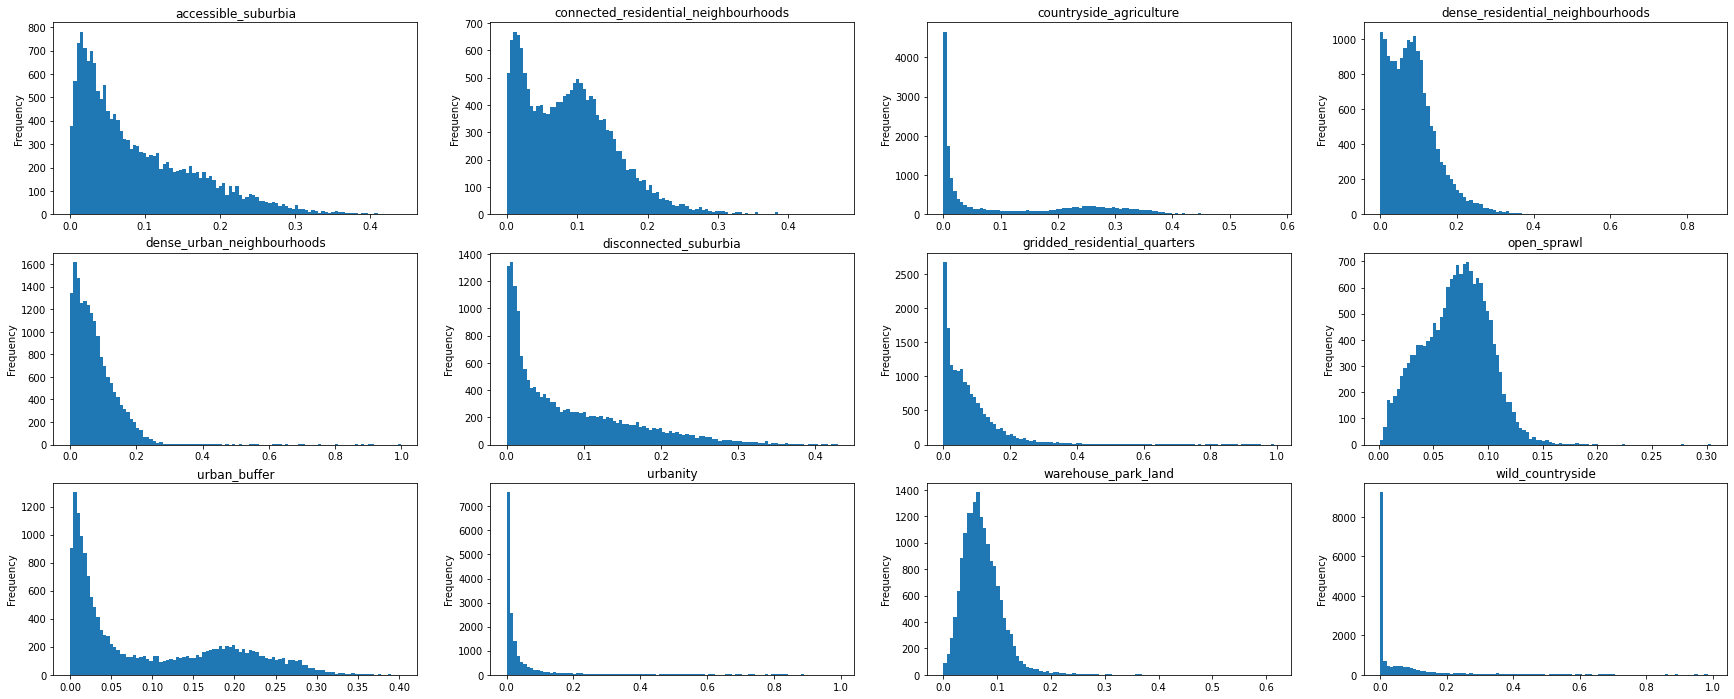

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(30, 12))
for i, (n, ax) in enumerate(zip(target.columns, axs.flatten())):
    pandas.Series(y_pred_probs[:, i]).plot.hist(bins=100, ax=ax)
    ax.set_title(n)

In [30]:
conf = confusion_matrix(y, y_pred, 12)

In [31]:
target.columns

Index(['accessible_suburbia', 'connected_residential_neighbourhoods',
       'countryside_agriculture', 'dense_residential_neighbourhoods',
       'dense_urban_neighbourhoods', 'disconnected_suburbia',
       'gridded_residential_quarters', 'open_sprawl', 'urban_buffer',
       'urbanity', 'warehouse_park_land', 'wild_countryside'],
      dtype='object')

([<matplotlib.axis.YTick at 0x7f078f808c40>,
 [Text(0, 0, 'urbanity'),
  Text(0, 1, 'dense_urban_neighbourhoods'),
  Text(0, 2, 'dense_residential_neighbourhoods'),
  Text(0, 3, 'connected_residential_neighbourhoods'),
  Text(0, 4, 'gridded_residential_quarters'),
  Text(0, 5, 'accessible_suburbia'),
  Text(0, 6, 'disconnected_suburbia'),
  Text(0, 7, 'open_sprawl'),
  Text(0, 8, 'warehouse_park_land'),
  Text(0, 9, 'urban_buffer'),
  Text(0, 10, 'countryside_agriculture'),
  Text(0, 11, 'wild_countryside')])

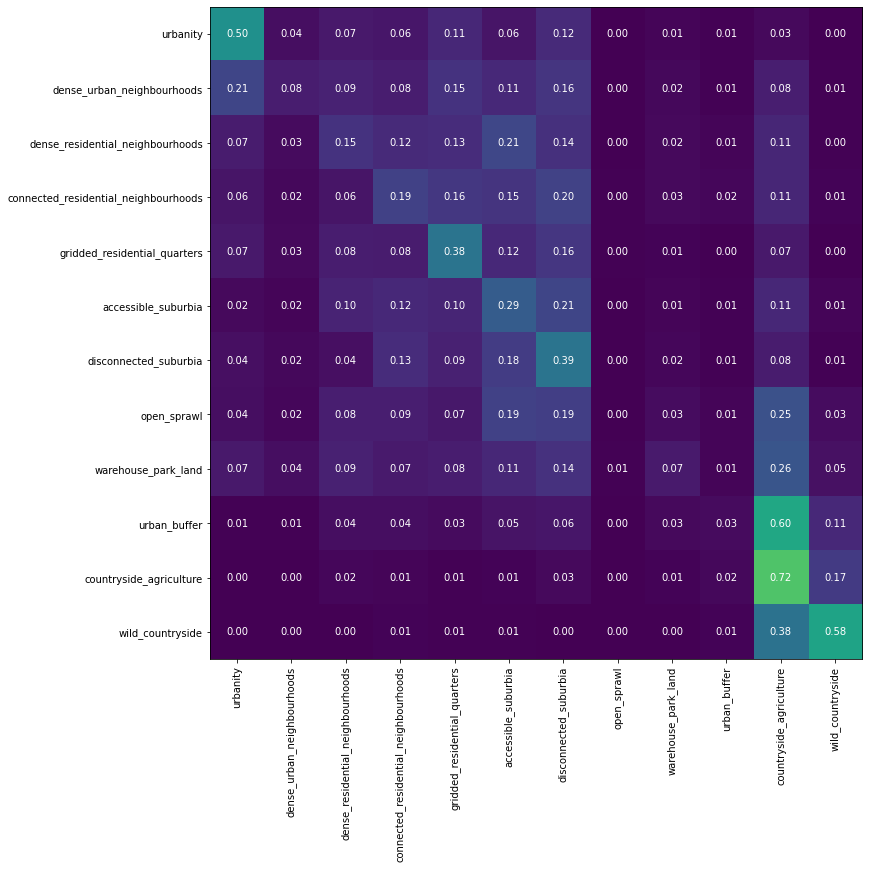

In [32]:
from itertools import product

fig, ax = plt.subplots(figsize=(12, 12))
order = numpy.array([9, 4, 3, 1, 6, 0, 5, 7, 10, 8, 2, 11], dtype=int)
a = pandas.DataFrame(conf).iloc[order, order].values
a = a / a.sum(axis=1)[:, numpy.newaxis]
a = pandas.DataFrame(a).values
ax.imshow(a, cmap="viridis", vmin=0, vmax=1)
for k, j in product(range(12), range(12)):
    ax.text(j, k, "{:.2f}".format(a[k, j]),
                   ha="center", va="center", color="w")
ticks = target.columns[order]
plt.xticks(range(12),ticks, rotation=90)
plt.yticks(range(12),ticks)
